In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('..')

import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from mrmr import mrmr_classif

from src.machinelearning import (
    ANNClassifier,
    evaluate_ann,
    evaluate_sklearn,
    get_predictions,
    train_ann,
    train_decisiontree,
    train_skoperules,
    train_xgboost,
)
from src.ml2rules import TreeRuler, ml2tree, sample_from_df
from src.utils import get_cc_mat, get_dataset, non_stratify_split, stratify_split

In [3]:
def plot_cc_ranges(df: pd.DataFrame) -> None:
    # Change plot style
    plt.style.use("ggplot")
    # Calculate the 1st and 3rd quartiles of df values
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    # Plot the mean of df values
    plt.figure(figsize=(10, 3))
    plt.barh(df.columns[::-1], df.mean()[::-1])
    plt.axvline(x=0, color="black", linestyle="-")
    plt.plot(q1, df.columns, "|", color="black", label="Q1", alpha=1)
    plt.plot(q3, df.columns, "|", color="black", label="Q3", alpha=1)
    for i, enzyme in enumerate(df.columns):
        plt.plot([q1[i], q3[i]], [enzyme, enzyme], color="black")
    plt.title("CC_XTR")
    plt.grid()
    plt.show()
    
def get_value_counts(df: pd.DataFrame) -> None:
    display(
        pd.DataFrame(
        data=[df['label'].value_counts(normalize=True).round(4), df['label'].value_counts()],
        index=["percentage", "absolute"]    
    ).T
    )


### Data loading

***Dataset shape: (200000, 259)

Enzyme: XTR
Common enzymes: ['HXK', 'PGI', 'TPI', 'ZWF', 'ATPM', 'ADK', 'NDR', 'PDA', 'XTR', 'XRI', 'XDH', 'XK']
Number of all enzymes: 86


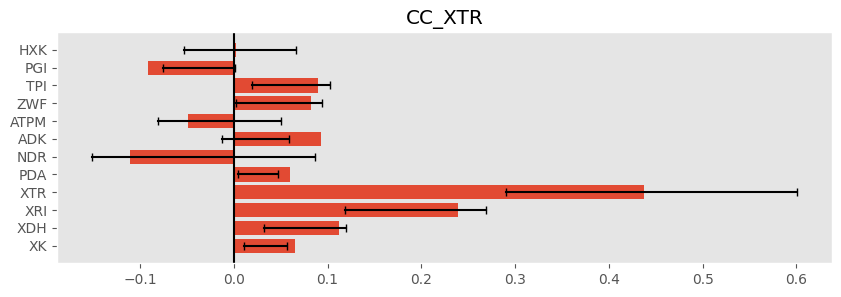

In [4]:
df = get_dataset(
    labels_file="../data/class_vector_train_ref.mat",
    params_file="../data/training_set_ref.mat",
    names_file="../data/paremeterNames.mat",
)

print(f"***Dataset shape: {df.shape}\n")

# Load FCC data
enzyme, commonEnz, allEnzymes, \
    commonConCoeff, allConCoeff = get_cc_mat("../data/ccXTR_ref.mat")

plot_cc_ranges(commonConCoeff)

In [5]:
# Create dataset for HXK enzyme; label 1 if CC < 0, 0 otherwise
idx_HXK = commonConCoeff[commonConCoeff["HXK"] < 0].index

df_HXK = df.drop("label", axis=1)
df_HXK["label"] = [1 if i in idx_HXK else 0 for i in df_HXK.index]
df_HXK["label"].value_counts(normalize=True).round(4)
df = df_HXK.copy()

# Create a dataframe with value_counts both percentage and absolute
display(
    pd.DataFrame(
    data=[df['label'].value_counts(normalize=True).round(4), df['label'].value_counts()],
    index=["percentage", "absolute"]    
).T
)

del df_HXK

,percentage,absolute
0,0.5287,105746.0
1,0.4713,94254.0


### Train - Test data split

In [10]:
# Split data
# X_train, X_test, y_train, y_test = non_stratify_split(
#     data=df, train_size=100000, target="label", zero_class_pct=0.60
# )

X_train, X_test, y_train, y_test = stratify_split(data=df, train_size=10000, target="label")

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print('Training set value counts:')
get_value_counts(train_df)

print('Test set value counts:')
get_value_counts(test_df)

Traininig set shape: (10000, 258)
Test set shape: (190000, 258)
Training set value counts:


,percentage,absolute
0,0.5287,5287.0
1,0.4713,4713.0


Test set value counts:


,percentage,absolute
0,0.5287,100459.0
1,0.4713,89541.0


### Feature Selection

In [11]:
K = int(100)
print(f"***Number of features to select: {K}")
selected_features = mrmr_classif(X=train_df.drop("label", axis=1), y=train_df["label"], K=K)

# keep only selected features
X_train = X_train[selected_features]
X_test = X_test[selected_features]

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(f'Training set shape: {train_df.shape}')
print(f'Test set shape: {test_df.shape}')

***Number of features to select: 100


100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


Training set shape: (10000, 101)
Test set shape: (190000, 101)


# Machine Learning

### Decision Tree - iSHRUNCK

In [ ]:
cart_model = train_decisiontree(X_train, y_train, scoring='matthews_corrcoef', n_trials=100)

In [13]:
# Save model using pickle
with open('../models/cart_model_10000_100.pkl', 'wb') as f:
    pickle.dump(cart_model, f)
    
cart_model

DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, min_samples_split=16)

In [14]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(cart_model, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(cart_model, X_test, y_test)

*** Evaluation on training set:
Accuracy: 0.6299
Precision: 0.6257
Recall: 0.5345
F1 score: 0.5765
ROC AUC score: 0.6247
MCC: 0.2539

*** Evaluation on test set:
Accuracy: 0.5991
Precision: 0.5865
Recall: 0.5061
F1 score: 0.5434
ROC AUC score: 0.5941
MCC: 0.1912


In [15]:
ruler = TreeRuler(df=train_df, tree_clf=cart_model, target="label")
ruler.get_rules()
print(f'Number of rules: {len(ruler.rules)}')
ruler.rules

Number of rules: 16


['if (XRI@nadh_c > 0.529) and (XRI@nad_c <= 0.888) and (ASN@pi_m <= 0.642) and (XRI@nadh_c <= 0.845) then class: 0 (proba: 65.53%) | based on 1,909 samples',
 'if (XRI@nadh_c <= 0.529) and (ASN@pi_m <= 0.582) and (XRI@nad_c <= 0.565) and (ADK@adp_c > 0.513) then class: 0 (proba: 61.49%) | based on 1,158 samples',
 'if (XRI@nadh_c > 0.529) and (XRI@nad_c <= 0.888) and (ASN@pi_m > 0.642) and (GND1@6pgl_c <= 0.866) then class: 0 (proba: 57.49%) | based on 1,075 samples',
 'if (XRI@nadh_c <= 0.529) and (ASN@pi_m <= 0.582) and (XRI@nad_c > 0.565) and (TPI@t3p_c > 0.315) then class: 1 (proba: 59.81%) | based on 1,035 samples',
 'if (XRI@nadh_c > 0.529) and (XRI@nad_c <= 0.888) and (ASN@pi_m <= 0.642) and (XRI@nadh_c > 0.845) then class: 0 (proba: 78.74%) | based on 823 samples',
 'if (XRI@nadh_c <= 0.529) and (ASN@pi_m <= 0.582) and (XRI@nad_c <= 0.565) and (ADK@adp_c <= 0.513) then class: 1 (proba: 50.48%) | based on 725 samples',
 'if (XRI@nadh_c <= 0.529) and (ASN@pi_m > 0.582) and (ASN@a

In [20]:
rule = ruler.get_rule_constraints(3)
print(rule)
sampled_df = sample_from_df(test_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

['XRI@nadh_c<=0.529', 'ASN@pi_m<=0.582', 'XRI@nad_c>0.565', 'TPI@t3p_c>0.315']
Number of parameter sets following the rule: 19596


,percentage,absolute
1,0.5638,11049.0
0,0.4362,8547.0


##### Skope - Rules

In [ ]:
skope_rules_clf = train_skoperules(X_train, y_train, scoring='matthews_corrcoef', n_iter=25)

In [22]:
# Save model using pickle
with open('../models/skoperules_model_10000_100.pkl', 'wb') as f:
    pickle.dump(skope_rules_clf, f)

skope_rules_clf

SkopeRules(feature_names=['XRI@nadh_c', 'NDR@nadp_c', 'ASN@pi_m', 'XRI@nad_c',
                          'XDH@xlt_c', 'NH4t@nh4_c', 'TPI@t3p_c', 'XK@xyll_c',
                          'ADK@adp_c', 'TDH@t3p_c', 'PGK@dpg_c', 'GND1@6pgl_c',
                          'PGI@f6p_c', 'ZWF@nadp_c', 'XDH@nadh_c', 'XK@adp_c',
                          'GPD1@dhap_c', 'XK@x5p_c', 'ZWF@6pgl_c', 'XDH@nad_c',
                          'TKL2@e4p_c', 'BIO@so4_c', 'GLYCt@glyc_c',
                          'TPI@dhap_c', 'LSC@suc_m', 'PDA@nadh_m', 'ADH1@nad_c',
                          'HXK@atp_c', 'XDH@xyll_c', 'LSC@succoa_m', ...],
           n_estimators=50, n_jobs=-1, precision_min=0.1, random_state=42,
           recall_min=0.2)

In [23]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(skope_rules_clf, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(skope_rules_clf, X_test, y_test)

*** Evaluation on training set:
Accuracy: 0.5532
Precision: 0.5165
Recall: 0.8150
F1 score: 0.6323
ROC AUC score: 0.5674
MCC: 0.1541

*** Evaluation on test set:
Accuracy: 0.5501
Precision: 0.5144
Recall: 0.8093
F1 score: 0.6290
ROC AUC score: 0.5641
MCC: 0.1463


In [24]:
# Print skope-rules rules
print(f'*** Number of rules {len(skope_rules_clf.rules_)}')

# Get rules
for i in skope_rules_clf.rules_:
    print(i)

*** Number of rules 74
('XRI@nadh_c <= 0.5808196067810059 and ASN@pi_m > 0.5217894017696381 and NH4t@nh4_c > 0.14190267771482468', (0.6435856146001073, 0.3195628997867804, 2))
('XRI@nadh_c <= 0.5959502756595612 and ASN@pi_m > 0.5426633358001709 and NH4t@nh4_c > 0.10052410140633583', (0.6383315733896515, 0.32026490066225166, 2))
('XRI@nadh_c <= 0.6347562372684479 and ASN@pi_m > 0.5820379853248596 and NH4t@nh4_c > 0.14325625449419022', (0.6450338600451467, 0.3056149732620321, 2))
('XRI@nadh_c <= 0.7245350480079651 and ASN@pi_m > 0.5820237398147583 and LSC@coa_m <= 0.7798764109611511', (0.6387959866220736, 0.3063352044907779, 2))
('XRI@nadh_c <= 0.5265026688575745 and ASN@pi_m <= 0.5828556716442108 and GPD2@g3p_c <= 0.9556194841861725', (0.4929145921103026, 0.3438418380977825, 2))
('XRI@nadh_c <= 0.5288165509700775 and ASN@pi_m > 0.5150039792060852 and XDH@xlt_c <= 0.8417251706123352', (0.6501766784452296, 0.29338293914429975, 2))
('XRI@nadh_c <= 0.5968270897865295 and ASN@pi_m <= 0.65209

In [34]:
rule = skope_rules_clf.rules_[0][0]
print(rule)
sampled_df = sample_from_df(test_df, rule, skope_rules=True)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

XRI@nadh_c <= 0.5808196067810059 and ASN@pi_m > 0.5217894017696381 and NH4t@nh4_c > 0.14190267771482468
Number of parameter sets following the rule: 43588


,percentage,absolute
1,0.6279,27370.0
0,0.3721,16218.0


##### XGBoost

In [ ]:
xgb_model = train_xgboost(X_train, y_train, scoring='matthews_corrcoef', n_trials=100)

In [37]:
# Save model using pickle
with open('../models/xgb_model_10000_100.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0894865206749493, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=88, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0.27503591761481216,
              reg_lambda=0.7264908231608147, ...)

In [38]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(xgb_model, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(xgb_model, X_test, y_test)

*** Evaluation on training set:
Accuracy: 0.8865
Precision: 0.8981
Recall: 0.8564
F1 score: 0.8767
ROC AUC score: 0.8849
MCC: 0.7724

*** Evaluation on test set:
Accuracy: 0.6797
Precision: 0.6716
Recall: 0.6271
F1 score: 0.6486
ROC AUC score: 0.6769
MCC: 0.3557


In [ ]:
xgb_preds = xgb_model.predict(X_train)
xgb2tree = ml2tree(X_train, xgb_preds, scoring='matthews_corrcoef', n_trials=100)

In [40]:
xgb2tree

DecisionTreeClassifier(max_depth=5, min_samples_leaf=13, min_samples_split=4)

In [42]:
evaluate_sklearn(xgb2tree, X_train, y_train)

print()

evaluate_sklearn(xgb2tree, X_test, y_test)

Accuracy: 0.6438
Precision: 0.6435
Recall: 0.5476
F1 score: 0.5917
ROC AUC score: 0.6386
MCC: 0.2823

Accuracy: 0.6068
Precision: 0.5964
Recall: 0.5122
F1 score: 0.5511
ROC AUC score: 0.6016
MCC: 0.2067


In [43]:
ruler = TreeRuler(df=train_df, tree_clf=xgb2tree, target="label")
ruler.get_rules()
ruler.rules

['if (XRI@nadh_c > 0.529) and (XRI@nad_c <= 0.883) and (ASN@pi_m <= 0.626) and (GND1@6pgl_c <= 0.953) and (XRI@nad_c <= 0.741) then class: 0 (proba: 86.33%) | based on 2,049 samples',
 'if (XRI@nadh_c <= 0.529) and (ASN@pi_m > 0.515) and (NH4t@nh4_c > 0.144) and (ASN@atp_m <= 0.887) and (ASN@pi_m > 0.652) then class: 1 (proba: 82.44%) | based on 1,264 samples',
 'if (XRI@nadh_c <= 0.529) and (ASN@pi_m <= 0.515) and (XRI@nad_c <= 0.565) and (PGI@f6p_c > 0.471) and (TKL2@e4p_c <= 0.941) then class: 0 (proba: 72.95%) | based on 843 samples',
 'if (XRI@nadh_c > 0.529) and (XRI@nad_c <= 0.883) and (ASN@pi_m > 0.626) and (GND1@6pgl_c <= 0.879) and (NH4t@nh4_c <= 0.517) then class: 0 (proba: 71.14%) | based on 603 samples',
 'if (XRI@nadh_c <= 0.529) and (ASN@pi_m <= 0.515) and (XRI@nad_c <= 0.565) and (PGI@f6p_c <= 0.471) and (ZWF@nadp_c <= 0.75) then class: 0 (proba: 60.48%) | based on 582 samples',
 'if (XRI@nadh_c <= 0.529) and (ASN@pi_m > 0.515) and (NH4t@nh4_c > 0.144) and (ASN@atp_m <=

In [52]:
rule = ruler.get_rule_constraints(1)
print(rule)
sampled_df = sample_from_df(test_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

['XRI@nadh_c<=0.529', 'ASN@pi_m>0.515', 'NH4t@nh4_c>0.144', 'ASN@atp_m<=0.887', 'ASN@pi_m>0.652']
Number of parameter sets following the rule: 23880


,percentage,absolute
1,0.6844,16344.0
0,0.3156,7536.0


### Neural Network

In [53]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = ANNClassifier(input_dim=X_train.shape[1], hidden_dim=2048,
                    output_dim=1, hidden_layers=4).to(device)

net = train_ann(net, X_train, y_train, num_epochs=1000, learning_rate=0.001, batch_size=2048)

Epoch 0, Loss: 0.692517
Epoch 10, Loss: 0.563378
Epoch 20, Loss: 0.368294
Epoch 30, Loss: 0.173567
Epoch 40, Loss: 0.000908
Epoch 50, Loss: 0.000089
Epoch 60, Loss: 0.000043
Epoch 70, Loss: 0.000020
Epoch 80, Loss: 0.000008
Epoch 90, Loss: 0.000003
Epoch 100, Loss: 0.000002
Epoch 110, Loss: 0.000001
Epoch 120, Loss: 0.000001
Epoch 130, Loss: 0.000001
Epoch 140, Loss: 0.000001
Epoch 150, Loss: 0.000001
Epoch 160, Loss: 0.000000
Epoch 170, Loss: 0.000000
Epoch 180, Loss: 0.000000
Epoch 190, Loss: 0.000000
Epoch 200, Loss: 0.000000
Epoch 210, Loss: 0.000000
Early stopping on epoch 217


In [54]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_ann(net, X_train, y_train)
print()

print('*** Evaluation on test set:')
evaluate_ann(net, X_test, y_test)

*** Evaluation on training set:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1: 1.0000
MCC: 1.0000

*** Evaluation on test set:
Accuracy: 0.6331
Precision: 0.6125
Recall: 0.6026
F1: 0.6075
MCC: 0.2631


In [ ]:
ann_preds = get_predictions(net, X_train)
ann2tree = ml2tree(X_train, ann_preds, scoring='precision', n_trials=100)

In [64]:
ann2tree

DecisionTreeClassifier(max_depth=2, min_samples_leaf=25, min_samples_split=25)

In [65]:
evaluate_sklearn(ann2tree, X_train, y_train)

print()

evaluate_sklearn(ann2tree, X_test, y_test)

Accuracy: 0.5993
Precision: 0.6355
Recall: 0.3514
F1 score: 0.4525
ROC AUC score: 0.5858
MCC: 0.1952

Accuracy: 0.5893
Precision: 0.6143
Recall: 0.3452
F1 score: 0.4421
ROC AUC score: 0.5760
MCC: 0.1720


In [66]:
ruler = TreeRuler(df=train_df, tree_clf=ann2tree, target="label")
ruler.get_rules()
ruler.rules

['if (XRI@nadh_c > 0.529) and (XRI@nad_c <= 0.888) then class: 0 (proba: 64.6%) | based on 3,997 samples',
 'if (XRI@nadh_c <= 0.529) and (ASN@pi_m <= 0.582) then class: 0 (proba: 51.66%) | based on 3,397 samples',
 'if (XRI@nadh_c <= 0.529) and (ASN@pi_m > 0.582) then class: 1 (proba: 64.5%) | based on 2,110 samples',
 'if (XRI@nadh_c > 0.529) and (XRI@nad_c > 0.888) then class: 1 (proba: 59.48%) | based on 496 samples']

In [68]:
rule = ruler.get_rule_constraints(2)
print(rule)
sampled_df = sample_from_df(test_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

['XRI@nadh_c<=0.529', 'ASN@pi_m>0.582']
Number of parameter sets following the rule: 39977


,percentage,absolute
1,0.6356,25411.0
0,0.3644,14566.0


### Exlainable Machine Learning

In [70]:
# xgb.plot_importance(xgb_model, importance_type='gain')
# plt.show()

2024-10-01 15:12:21.500741: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-01 15:12:21.514388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 15:12:21.528657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 15:12:21.532653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 15:12:21.546743: I tensorflow/core/platform/cpu_feature_guar

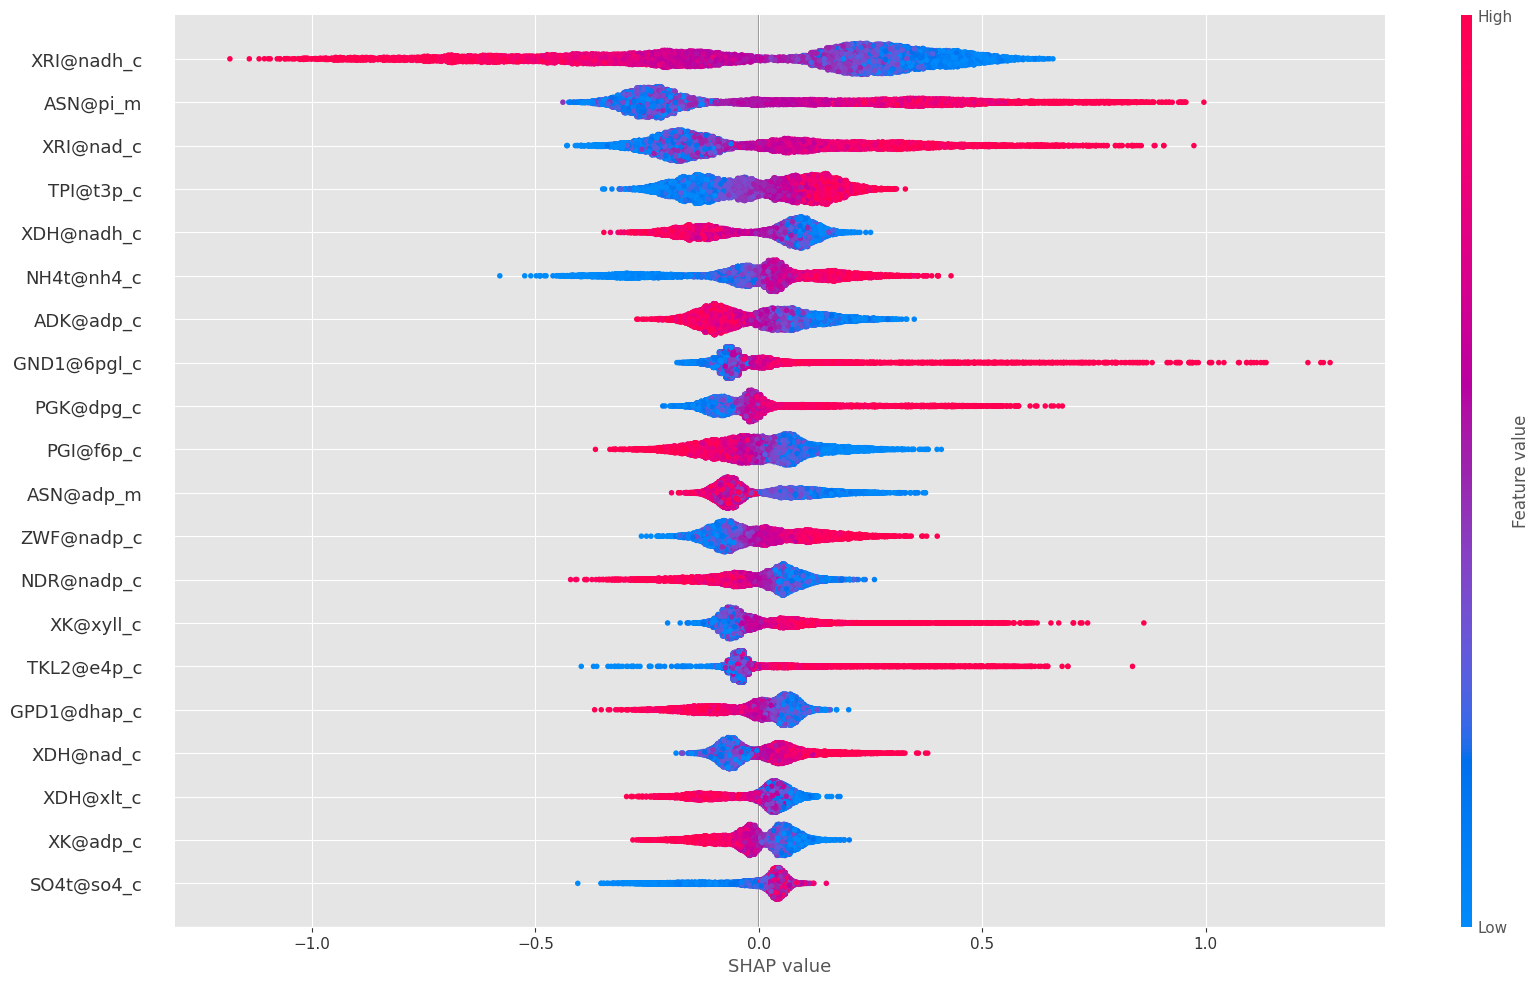

In [71]:
import shap

# Create a TreeExplainer for the xgb_model
explainer = shap.TreeExplainer(xgb_model)
# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X_train)
# Display the SHAP summary plot

fig = plt.figure()
shap.summary_plot(shap_values, X_train, plot_type="dot", show=False)
plt.gcf().set_size_inches(20,10)
plt.xlabel("SHAP value")
plt.show()

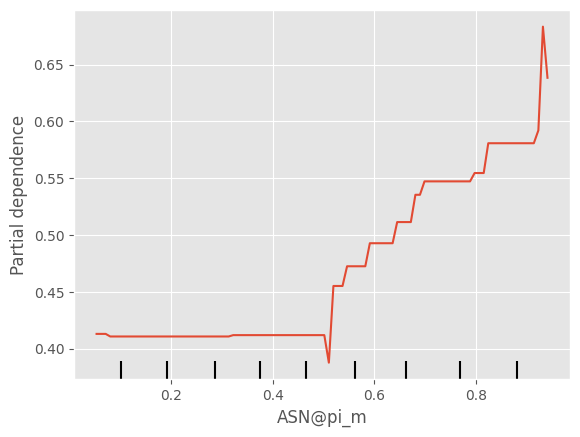

In [24]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(xgb_model, X_train, features=['ASN@pi_m'])
plt.show()